## Validate PyBaMM with real results.

Nesse notebook, queremos validar o modelo PyBaMM usando dados experimentais reais -- nesse caso, temos o dataset *Severson (2019)*.


O primeiro passo é preparar o código, caso esteja sendo executado no Google Colab ou localmente.

In [1]:
# importing basic libs
import os
import sys

# setting up code to run in google colab
git_repo_url = "https://github.com/SarvTex/june_sciml_workshop.git"
repo_name = "june_sciml_workshop"

if 'google.colab' in sys.modules:
    # Google colab setup
    print("> Code running in Colab env ===")

    if not repo_name in os.getcwd().split(os.sep) and not repo_name in os.listdir():
        print("> Cloning repo (dataset) ===")
        !git clone {git_repo_url}
    else:
      print("> Repo already cloned ===")

    if repo_name in os.listdir():
        os.chdir(repo_name)
    print(f"> Currently in correct folder ({os.getcwd()}) ===")

else:
    # Running locally setup
    print("> Running locally. Assuming correct folder structure ===")

!ls

> Running locally. Assuming correct folder structure ===
/bin/bash: /home/lucas/anaconda3/envs/tf_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
01_pinnModel.ipynb		README.md
02_udeModel.ipynb		data
11_pybammCompareModels.ipynb	enviroment.yml
12_pybammAgingExperiment.ipynb	explore_data.ipynb
13_pybammCreateData.ipynb	imgs
14_pybammSeversonCompare.ipynb	test.ipynb


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DIR_PATH = "./data/some_severson_raw/"
files = os.listdir(DIR_PATH)
files

['b1c28.pkl', 'b1c44.pkl', 'b1c41.pkl', 'b1c9.pkl', 'b1c33.pkl']

In [3]:
# open a random file as an example:
idx = np.random.randint(0, len(files))
file = pd.read_pickle(os.path.join(DIR_PATH, files[idx]))
# print file data:
print(f"Battery data.\n",
      f"\t- Charge policy: {file['charge_policy']}\n",
      f"\t- Cycle life: {file['cycle_life']}\n")

# cycle keys:
batt_cycles = file['cycles']
print(batt_cycles['1'].keys())

Battery data.
 	- Charge policy: 8C(15%)-3.6C
 	- Cycle life: [[1051.]]

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])


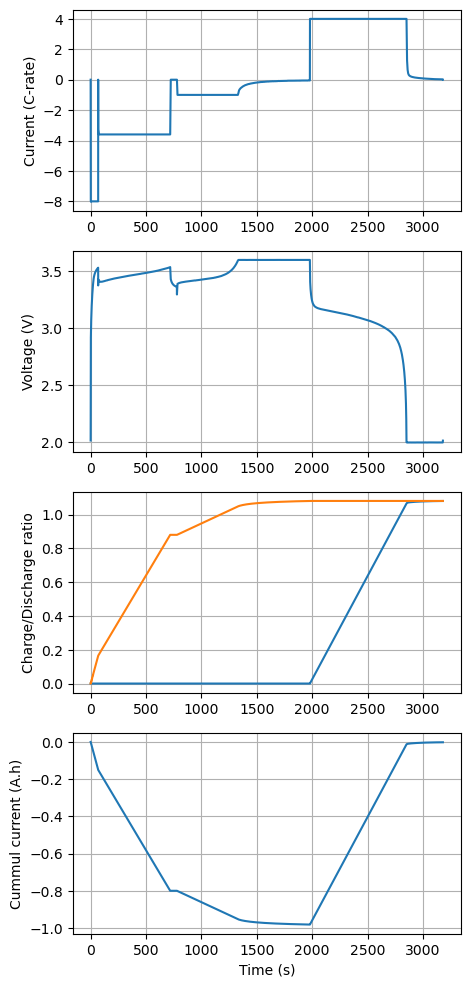

In [4]:
def nth_cycle_data(severson_cycle_data, n_index):
    # make things slightly more convinient
    return severson_cycle_data[str(n_index + 1)]

## inherit some cycle data and plot it
cyc = nth_cycle_data(batt_cycles, 1)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(5,12))

# current
ax1.plot(cyc['t']*60, -cyc['I'])
ax1.set_ylabel("Current (C-rate)")
ax1.grid(True)
# voltage
ax2.plot(cyc['t']*60, cyc['V'])
ax2.set_ylabel("Voltage (V)")
ax2.grid(True)
# charge/discharge
ax3.plot(cyc['t']*60, cyc['Qd'])
ax3.plot(cyc['t']*60, cyc['Qc'])
ax3.set_ylabel("Charge/Discharge ratio")
ax3.grid(True)
# cummul current 
ax4.plot(cyc['t'][1:]*60, np.cumsum(np.multiply( -cyc['I'][1:]/3600 , (cyc['t'][1:]-cyc['t'][0:-1])*60 )))
ax4.set_ylabel("Cummul current (A.h)")
ax4.set_xlabel("Time (s)")
ax4.grid(True)